<a href="https://colab.research.google.com/github/delciocapolo/neuralNetworkClassificationModel/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import sklearn.datasets as datasets

# defining config. to the matplotlib.pyplot

In [57]:
# Changing the size of the figure that will be displayed
plt.style.use('dark_background')
# Changing the style, to dark (in the background)
plt.rcParams['figure.figsize'] = (10, 6)

# Defining Dataset

In [58]:
# in this code, we'll use the dataset make_moons
# you can adapt to your training dataset

X, y = datasets.make_moons(n_samples=500, noise=0.05)

## viewing datas and features

In [59]:
config_dataset = {
    'feature 1': X[:, 0],
    'feature 2': X[:, 1],
    'target': y
}
df = pd.DataFrame(config_dataset)
df.head()

,feature 1,feature 2,target
0,0.709830,-0.501719,1
1,1.996753,0.178510,1
2,1.701868,-0.275974,1
3,-0.995302,0.193433,0
4,1.193102,-0.500193,1


In [60]:
# np.unique, returns unique values in the list
classes = np.unique(y, return_counts=True)

for label, qt_label in zip(classes[0], classes[1]):
  print(f'Class: {label}\t Counts: {qt_label}')

# viewing the shape
print(f'\n\t\tShape\n{X.shape = } | {y.shape = }')

Class: 0	 Counts: 250
Class: 1	 Counts: 250

		Shape
X.shape = (500, 2) | y.shape = (500,)


# displaying the datas

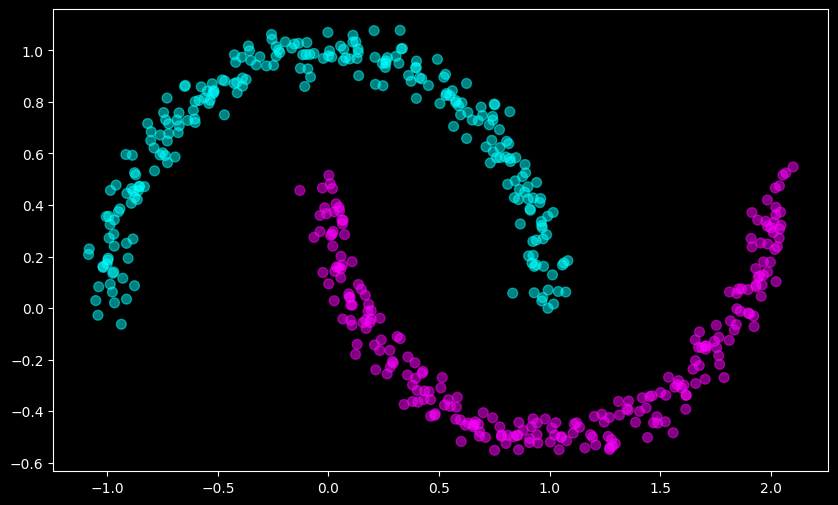

In [61]:
# visualization of the data disposition
plt.scatter(X[:,0], X[:,1], c=y, s=50, alpha=0.5, cmap='cool')

# Model

- Inicializing weights and bias
- FeedForward
- loss
- Backpropagation
- Fit

In [62]:
class NNModel:
  def __init__(self, X: np.ndarray, y: np.ndarray, hidden_neurons: int, output_neurons: int | None):
    np.random.seed(8)
    self.X = X
    self.y = y
    self.hidden_neurons = hidden_neurons

    # standardizing the number of neural network outputs
    countClassesInDataset = np.unique(self.y).size
    self.output_neurons = output_neurons if output_neurons != None else countClassesInDataset

    # number of neurons in the input
    self.input_neurons = self.X.shape[1]

    # inicialing weights and bias
    # Xavier Inicialization
    self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
    self.B1 = np.zeros((1, self.hidden_neurons))
    self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.output_neurons)
    self.B2 = np.zeros((1, self.output_neurons))

    # model' dictionary
    self.model_dict = {'W1': self.W1, 'B1': self.B1, 'W2': self.W2, 'B2': self.B2}

    # z1 => is the sum of the values that enter the hidden layer (in the first neuron)
    self.z1 = 0
    # f1 => is the activation function (in this first neuron)
    self.f1 = 0

  # computing the neural network' prediction
  def forward(self, X: np.ndarray) -> np.ndarray:
    # Eq. da reta (1)
    self.z1 = X.dot(self.W1) + self.B1

    # in this case, it'll be hyperbolic tangent
    self.f1 = np.tanh(self.z1)

    # z2 => is the sum of the values that enter the hidden layer (in the first neuron)
    z2 = self.f1.dot(self.W2) + self.B2

    # Softmax
    return self.softmax(z2)

  def softmax(self, z):
    exp_values = np.exp(z)
    softmax = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return softmax

  # Cross-Entropy
  def loss(self, softmax):
    # predictions => responsible for storing the values of the class that was predicted
    predictions = np.zeros(self.y.shape[0])

    for i, current_index in enumerate(self.y):
      predicted = softmax[i][current_index]
      predictions[i] = predicted

    # applying Cross-Entropy' formula
    log_prob = -np.log(predicted)
    return log_prob/self.y.shape[0]

  def backpropagation(self, softmax: np.ndarray, learning_rate: float) -> None:
    delta2 = np.copy(softmax)
    delta2[range(self.X.shape[0]), self.y] -= 1
    dW2 = (self.f1.T).dot(delta2)
    dB2 = np.sum(delta2, axis=0, keepdims=True)


    delta1 = delta2.dot(self.W2.T)*(1-np.power(np.tanh(self.z1), 2))
    dW1 = (self.X.T).dot(delta1)
    dB1 = np.sum(delta1, axis=0, keepdims=True)

    # updating weights and bias
    self.W1 -= learning_rate*dW1
    self.W2 -= learning_rate*dW2
    self.B1 -= learning_rate*dB1
    self.B2 -= learning_rate*dB2

  def fit(self, epochs:int, lr:float=0.001, show_plot: bool = False):
      for epoch in range(epochs):
          outputs = self.forward(self.X)
          loss = self.loss(outputs)
          self.backpropagation(outputs, lr)

          # accuracy
          prediction = np.argmax(outputs, axis=1)
          correct = (prediction == self.y).sum()
          accuracy = correct/self.y.shape[0]

          if int((epoch+1) % (epochs/10)) == 0:
              print(f'Epoch: [{epoch+1} / {epochs}] Accuracy: {accuracy:.3f} Loss: {loss.item():.4f}')
              self.graphic(predictions=prediction, view=show_plot)

      return prediction

  def graphic(self, predictions: np.ndarray, view: bool = False):
      if self.input_neurons == 2 and view:
          plt.scatter(self.X[:, 0], self.X[:, 1], s=50, c=predictions, cmap='cool', alpha=0.7)
          plt.show()
          return
      elif self.input_neurons == 3 and view:
          ax = plt.axes(projection='3d')
          ax.scatter3D(self.X[:,0], self.X[:,1], self.X[:,2], s=40, c=predictions, cmap='cool', alpha=0.5)
          plt.show()
          return

# Passing values to the Neural Network

In [63]:
hidden_neuros = 10
output_neurons = 2
learning_rate = 0.001
epochs = 250

In [64]:
model = NNModel(X, y, hidden_neuros, output_neurons)
result = model.fit(epochs, learning_rate)

Epoch: [25 / 250] Accuracy: 0.896 Loss: 0.0001
Epoch: [50 / 250] Accuracy: 0.914 Loss: 0.0001
Epoch: [75 / 250] Accuracy: 0.932 Loss: 0.0001
Epoch: [100 / 250] Accuracy: 0.946 Loss: 0.0001
Epoch: [125 / 250] Accuracy: 0.970 Loss: 0.0001
Epoch: [150 / 250] Accuracy: 0.974 Loss: 0.0000
Epoch: [175 / 250] Accuracy: 0.982 Loss: 0.0000
Epoch: [200 / 250] Accuracy: 0.994 Loss: 0.0000
Epoch: [225 / 250] Accuracy: 0.996 Loss: 0.0000
Epoch: [250 / 250] Accuracy: 1.000 Loss: 0.0000


# Saving the model

In [65]:
# create or save the model
with open('trained_model.pickle', 'wb') as file:
  pk.dump(model, file)

In [66]:
# load the saved model
with open('trained_model.pickle', 'rb') as file:
  trained_model = pk.load(file)